In [32]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as si
from sklearn.svm import SVC
from collections import OrderedDict
plt.rcParams['axes.formatter.limits'] = [-3,3]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1 Support Vector Machines

# 1.1 Example Dataset 1

In [33]:
a = si.loadmat('ex6_octave/ex6data1.mat')
X = a['X']
y = a['y'].flatten()

In [34]:
def plotData(X, y):
    
    # get indices of 1 and 0 y values
    pos = y == 1
    neg = y == 0
    
    # plot positive (i.e., accepted) points
    plt.plot(X[pos,0], X[pos,1], '+', color='k', ms=7, mew=2)
    
    # plot negative (i.e., not accepted) points
    plt.plot(X[neg,0], X[neg,1], 'o', color='y', ms=7)

    
def visualizeBoundary(X, y, clf):
    
    # plot data on top of bounary
    plotData(X, y)
    
    # make classification predictions over a grid of values
    x1 = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    x2 = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    vals = np.zeros(X1.shape)
    for ii in range(100):
        this_X = np.vstack((X1[:,ii], X2[:,ii])).T
        vals[:, ii] = clf.predict(this_X)
        
    plt.contour(X1, X2, vals, [0,0])

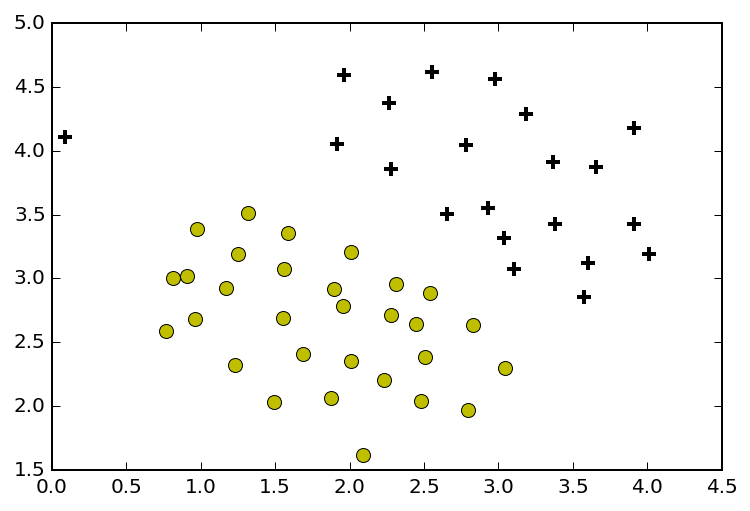

In [35]:
plotData(X, y)

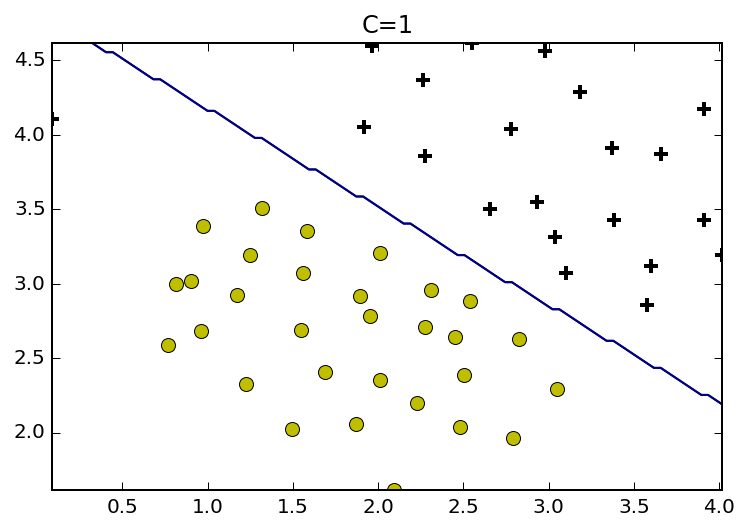

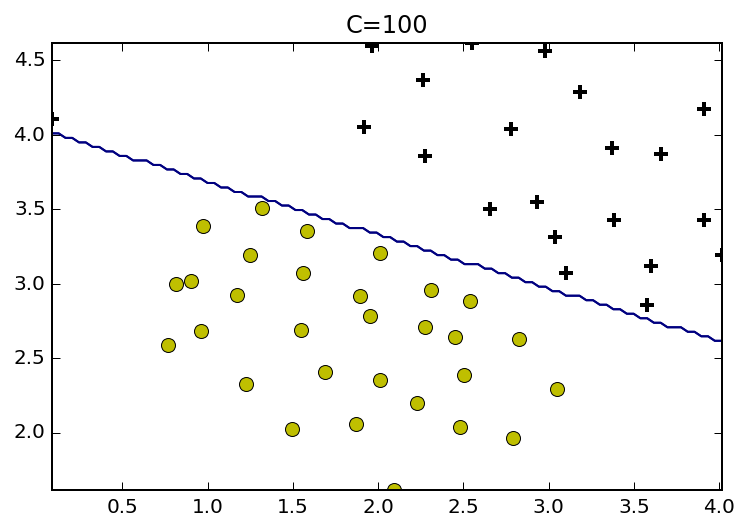

In [36]:
# train SVM with different C values

# C = 1
C = 1.0
clf = SVC(C=C, kernel='linear')
clf.fit(X, y) 

visualizeBoundary(X, y, clf)
plt.title('C=1')

# C = 100
C = 100.0
clf = SVC(C=C, kernel='linear')
clf.fit(X, y) 

plt.figure()
visualizeBoundary(X, y, clf)
plt.title('C=100')

## 1.2 Gaussian Kernel

### 1.2.2 Example Dataset 2

In [37]:
a = si.loadmat('ex6_octave/ex6data2.mat')
X = a['X']
y = a['y'].flatten()

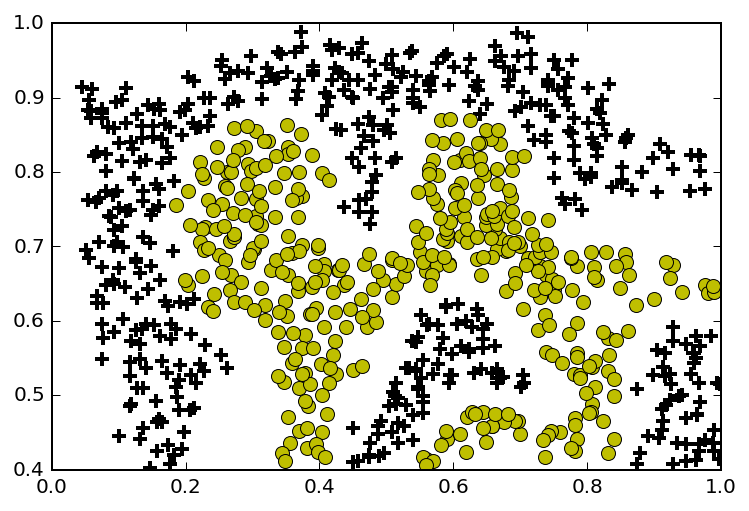

In [38]:
plotData(X, y)

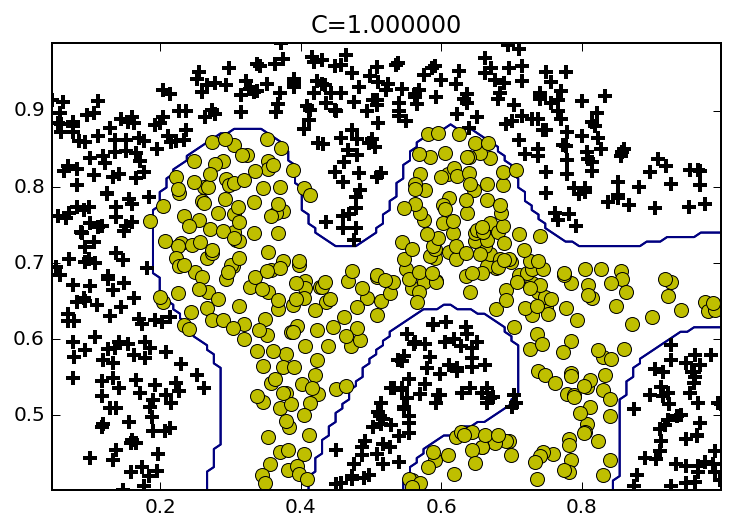

In [39]:
C = 1
sigma = 0.1
gamma = 1 / 2 / sigma**2

# train SVM with gaussian kernel
clf = SVC(C=C, kernel='rbf', gamma=gamma)
clf.fit(X, y) 

visualizeBoundary(X, y, clf)
plt.title('C=%f'%C)

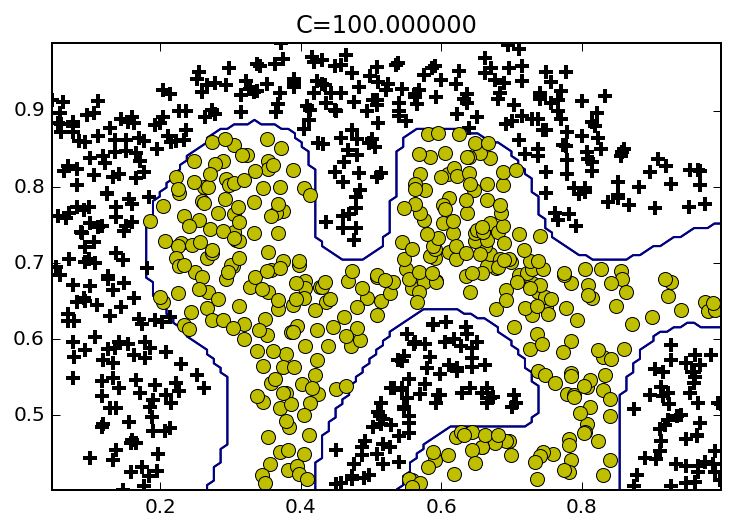

In [40]:
C = 100
sigma = 0.1
gamma = 1 / 2 / sigma**2

# train SVM with gaussian kernel
clf = SVC(C=C, kernel='rbf', gamma=gamma)
clf.fit(X, y) 

visualizeBoundary(X, y, clf)
plt.title('C=%f'%C)

### Example Dataset 3

In [41]:
a = si.loadmat('ex6_octave/ex6data3.mat')
X = a['X']
y = a['y'].flatten()
Xval = a['Xval']
yval = a['yval'].flatten()

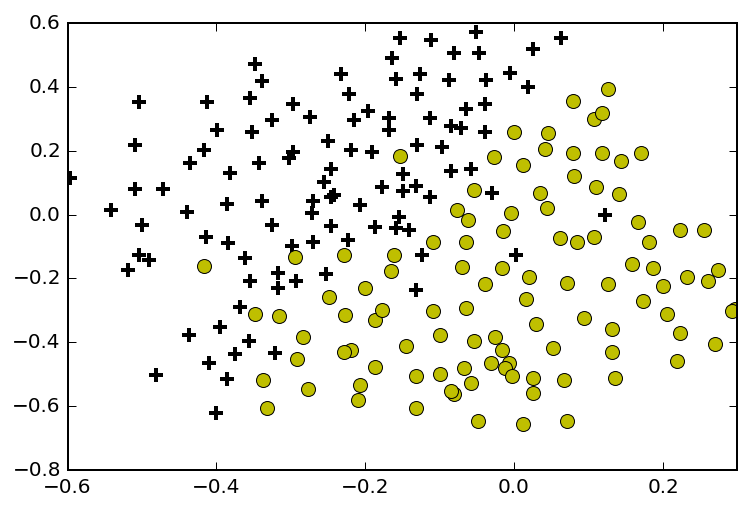

In [42]:
plotData(X, y)

0.07


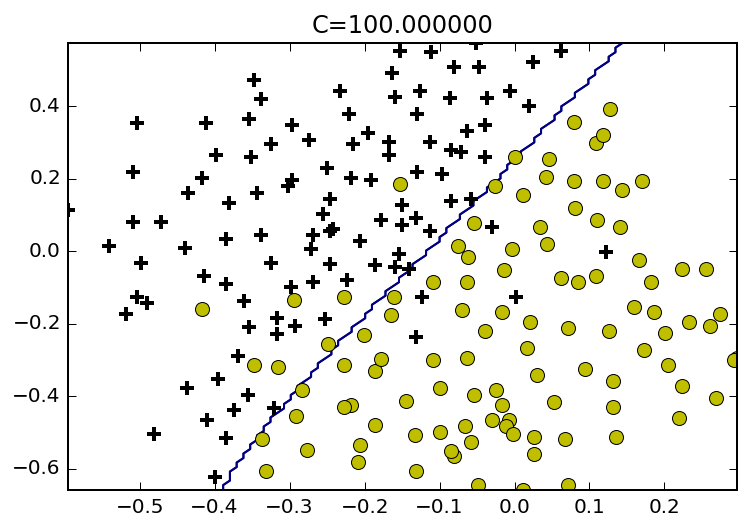

In [43]:
C = 100
sigma = 1.1
gamma = 1 / 2 / sigma**2

# train SVM with gaussian kernel
clf = SVC(C=C, kernel='rbf', gamma=gamma)
clf.fit(X, y) 

p = clf.predict(Xval)
print np.mean(p!=yval)

visualizeBoundary(X, y, clf)
plt.title('C=%f'%C)

In [44]:
Cs = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
sigmas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]

pmat = np.zeros((len(Cs)**2, 3))
ct = 0
for ii, C in enumerate(Cs):
    for jj, sigma in enumerate(sigmas):
        gamma = 1 / 2 / sigma**2
        
        # train SVM with gaussian kernel
        clf = SVC(C=C, kernel='rbf', gamma=gamma)
        clf.fit(X, y) 
        
        # predict with cross-validation set
        p = clf.predict(Xval)
        
        pmat[ct, :] = C, sigma, np.mean(p!=yval)
        ct += 1
        
        

1.0 0.1
0.035


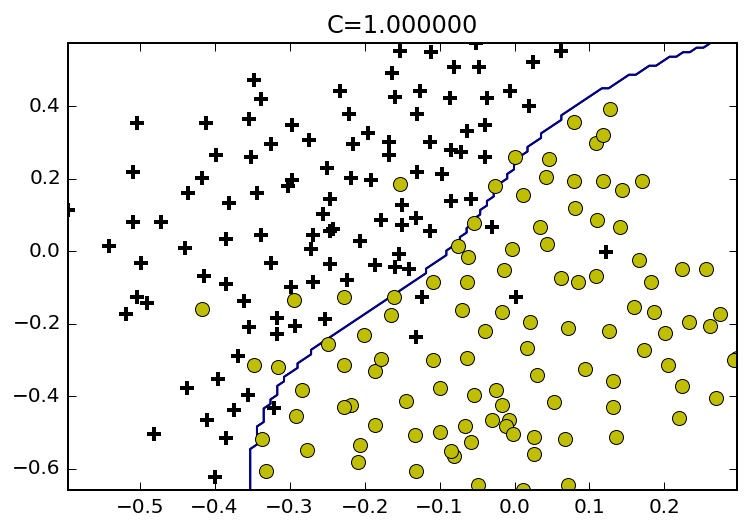

In [45]:
ind = np.argmin(pmat[:,2])
C, sigma = pmat[ind,0], pmat[ind,1]
print C, sigma
sigma = 0.3

gamma = 1 / 2 / sigma**2

# train SVM with gaussian kernel
clf = SVC(C=C, kernel='rbf', gamma=gamma)
clf.fit(X, y) 

p = clf.predict(Xval)
print np.mean(p!=yval)

visualizeBoundary(X, y, clf)
plt.title('C=%f'%C)

# 2 Spam Classification

In [46]:
import re
import nltk

## 2.1 Preprocessing Emails

In [47]:
def readFile(filename):
    
    with open(filename, 'r') as fid:
        file_contents = fid.read()
    
    return file_contents

def getVocabList():
    
    # read vocab file
    vfile = np.genfromtxt('ex6_octave/vocab.txt', dtype='S42')
    
    # dictionary
    x = OrderedDict()
    for ct, word in vfile:
        x[word] = int(ct)
    
    return x

def processEmail(email_contents):
    
    # get Vocabulary
    vocab = getVocabList()
    
    # Init word indices
    word_indices = []
    
    # lower case
    email_contents = email_contents.lower()
            
    # strip all HTML
    email_contents = re.sub('<[^<>]+>', ' ', email_contents)
    
    # Handle numbers
    email_contents = re.sub('[0-9]+', 'number', email_contents)
    
    # Handle URLS
    email_contents = re.sub('(http|https)://[^\s]*', 'httpaddr', email_contents)
    
    # Handle email addresses
    email_contents = re.sub('[^\s]+@[^\s]+', 'emailaddr', email_contents)
    
    # handle $ sign
    email_contents = re.sub('[$]+', 'dollar', email_contents)
    
    # tokenize
    tokens = re.split( '[ ' + 
                      re.escape("@$/#.-:&*+=[]?!(){},'\">_<;%") + ']', 
                      email_contents )
    
    stemmer = nltk.stem.PorterStemmer()
    for token in tokens:
        token = re.sub('[^a-zA-Z0-9]','', token)
        token = stemmer.stem(token.strip())
        
        if len(token) > 1 and token in vocab:
            word_indices.append(vocab[str(token)])
        
    return word_indices
    
    
    

In [48]:
email_contents = readFile('ex6_octave/emailSample1.txt')
print email_contents

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




In [49]:
word_indices = processEmail(email_contents)

In [50]:
word_indices

[86,
 916,
 794,
 1077,
 883,
 370,
 1699,
 790,
 1822,
 1831,
 883,
 431,
 1171,
 794,
 1002,
 1893,
 1364,
 592,
 1676,
 238,
 162,
 89,
 688,
 945,
 1663,
 1120,
 1062,
 1699,
 375,
 1162,
 479,
 1893,
 1510,
 799,
 1182,
 1237,
 810,
 1895,
 1440,
 1547,
 181,
 1699,
 1758,
 1896,
 688,
 1676,
 992,
 961,
 1477,
 71,
 530,
 1699,
 531]

## 2.2 Extracting Features from Emails

In [51]:
def emailFeatures(word_indices):
    
    n = 1899
    x = np.zeros(n)
    x[np.array(word_indices)-1] = 1
    
    return x
        

In [52]:
features = emailFeatures(word_indices)
print features

[ 0.  0.  0. ...,  0.  0.  0.]


## 2.3 Train SVM for spam classification

In [53]:
# load in spam training set
a = a = si.loadmat('ex6_octave/spamTrain.mat')
X = a['X']
y = a['y'].flatten()

a = si.loadmat('ex6_octave/spamTest.mat')
Xtest = a['Xtest']
ytest = a['ytest'].flatten()

In [54]:
# train data set
C = 0.1
clf = SVC(C=C, kernel='linear')
clf.fit(X, y) 


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
print 'Trainin Accuracy = {0} percent'.format(
    clf.score(X, y)*100)

Trainin Accuracy = 99.825 percent


In [56]:
# run on test set
print 'Test Accuracy = {0} percent'.format(
    clf.score(Xtest, ytest)*100)

Test Accuracy = 98.9 percent


## 2.4 Top classifiers

In [57]:
idx = np.argsort(clf.coef_)[0][::-1]
vocabList = getVocabList()
for ii in range(15):
    print vocabList.keys()[idx[ii]]

our
click
remov
guarante
visit
basenumb
dollar
will
price
pleas
most
nbsp
lo
ga
hour


## 2.5 Test on some examples

In [58]:
ex1 = readFile('ex6_octave/spamSample1.txt')
word_indices = processEmail(ex1)
features = emailFeatures(word_indices)

print ex1

Do You Want To Make $1000 Or More Per Week?

 

If you are a motivated and qualified individual - I 
will personally demonstrate to you a system that will 
make you $1,000 per week or more! This is NOT mlm.

 

Call our 24 hour pre-recorded number to get the 
details.  

 

000-456-789

 

I need people who want to make serious money.  Make 
the call and get the facts. 

Invest 2 minutes in yourself now!

 

000-456-789

 

Looking forward to your call and I will introduce you 
to people like yourself who
are currently making $10,000 plus per week!

 

000-456-789



3484lJGv6-241lEaN9080lRmS6-271WxHo7524qiyT5-438rjUv5615hQcf0-662eiDB9057dMtVl72




In [59]:
p = clf.predict(features.reshape((1, len(features))))
print p

[1]


In [60]:
ex2 = readFile('ex6_octave/spamSample2.txt')
word_indices = processEmail(ex2)
features = emailFeatures(word_indices)

print ex2

Best Buy Viagra Generic Online

Viagra 100mg x 60 Pills $125, Free Pills & Reorder Discount, Top Selling 100% Quality & Satisfaction guaranteed!

We accept VISA, Master & E-Check Payments, 90000+ Satisfied Customers!
http://medphysitcstech.ru





In [61]:
p = clf.predict(features.reshape((1, len(features))))
print p

[1]


In [62]:
ex3 = readFile('ex6_octave/emailSample1.txt')
word_indices = processEmail(ex3)
features = emailFeatures(word_indices)

print ex3

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




In [63]:
p = clf.predict(features.reshape((1, len(features))))
print p

[0]


In [64]:
ex4 = readFile('ex6_octave/emailSample2.txt')
word_indices = processEmail(ex4)
features = emailFeatures(word_indices)

print ex4

Folks,
 
my first time posting - have a bit of Unix experience, but am new to Linux.

 
Just got a new PC at home - Dell box with Windows XP. Added a second hard disk
for Linux. Partitioned the disk and have installed Suse 7.2 from CD, which went
fine except it didn't pick up my monitor.
 
I have a Dell branded E151FPp 15" LCD flat panel monitor and a nVidia GeForce4
Ti4200 video card, both of which are probably too new to feature in Suse's default
set. I downloaded a driver from the nVidia website and installed it using RPM.
Then I ran Sax2 (as was recommended in some postings I found on the net), but
it still doesn't feature my video card in the available list. What next?
 
Another problem. I have a Dell branded keyboard and if I hit Caps-Lock twice,
the whole machine crashes (in Linux, not Windows) - even the on/off switch is
inactive, leaving me to reach for the power cable instead.
 
If anyone can help me in any way with these probs., I'd be really grateful -
I've searched the 'ne

In [65]:
p = clf.predict(features.reshape((1, len(features))))
print p

[0]
